In [1]:
from isochrones.dartmouth import Dartmouth_Isochrone
dar = Dartmouth_Isochrone()

In [2]:
%%file example.obs
name band resolution mag e_mag separation pa relative
twomass J 2.8 10 0.02 0 0 False 
twomass H 2.9 9.6 0.02 0 0 False 
twomass K 3.0 9.4 0.02 0 0 False 
UKIRT J 1.0 11 0.02 0 0 True 
UKIRT J 1.0 14.5 0.02 2. 280 True 
nirc2 K 0.1 0 0 0 0 True 
nirc2 K 0.1 4.0 0.03 2.1 274 True 
nirc2 K 0.1 1.5 0.03 0.3 123 True


Overwriting example.obs


In [3]:
import pandas as pd

df = pd.read_table('example.obs', delim_whitespace=True)#, index_col=[0,1])
df

,name,band,resolution,mag,e_mag,separation,pa,relative
0,twomass,J,2.8,10.0,0.02,0.0,0,False
1,twomass,H,2.9,9.6,0.02,0.0,0,False
2,twomass,K,3.0,9.4,0.02,0.0,0,False
3,UKIRT,J,1.0,11.0,0.02,0.0,0,True
4,UKIRT,J,1.0,14.5,0.02,2.0,280,True
5,nirc2,K,0.1,0.0,0.00,0.0,0,True
6,nirc2,K,0.1,4.0,0.03,2.1,274,True
7,nirc2,K,0.1,1.5,0.03,0.3,123,True


In [4]:
from isochrones.observation import ObservationTree

tree = ObservationTree.from_df(df)
tree.print_ascii()

root
 ╚═ twomass K=(9.4, 0.02) @(0.00, 0)
    ╚═ twomass H=(9.6, 0.02) @(0.00, 0)
       ╚═ twomass J=(10.0, 0.02) @(0.00, 0)
          ╠═ UKIRT J=(11.0, 0.02) @(0.00, 0)
          ║  ╠═ nirc2 K=(0.0, 0.0) @(0.00, 0)
          ║  ╚═ nirc2 K=(1.5, 0.03) @(0.30, 123)
          ╚═ UKIRT J=(14.5, 0.02) @(2.00, 280)
             ╚═ nirc2 K=(4.0, 0.03) @(2.10, 274)


In [5]:
tree.define_models(dar, N=(2,1,1), index=(0,0,1))
tree.print_ascii()

root
 ╚═ twomass K=(9.4, 0.02) @(0.00, 0)
    ╚═ twomass H=(9.6, 0.02) @(0.00, 0)
       ╚═ twomass J=(10.0, 0.02) @(0.00, 0)
          ╠═ UKIRT J=(11.0, 0.02) @(0.00, 0)
          ║  ╠═ nirc2 K=(0.0, 0.0) @(0.00, 0)
          ║  ║  ╠═ 0_0
          ║  ║  ╚═ 0_1
          ║  ╚═ nirc2 K=(1.5, 0.03) @(0.30, 123)
          ║     ╚═ 0_2
          ╚═ UKIRT J=(14.5, 0.02) @(2.00, 280)
             ╚═ nirc2 K=(4.0, 0.03) @(2.10, 274)
                ╚═ 1_0


In [6]:
pars = [1.0,0.9,0.8,9.5,0.0,200,0.1,0.6,9.3,0.1,300,0.2]
pdict = tree.p2pardict(pars)

In [7]:
tree.print_ascii(pars)

root
 ╚═ twomass K=(9.4, 0.02) @(0.00, 0); model=9.02 (-179.188803283)
    ╚═ twomass H=(9.6, 0.02) @(0.00, 0); model=9.08 (-336.430840387)
       ╚═ twomass J=(10.0, 0.02) @(0.00, 0); model=9.49 (-329.553904114)
          ╠═ UKIRT J=(11.0, 0.02) @(0.00, 0); model=9.52 (0)
          ║  ╠═ nirc2 K=(0.0, 0.0) @(0.00, 0); model=9.34 (0)
          ║  ║  ╠═ 0_0: [1.0, 9.5, 0.0, 200, 0.1]
          ║  ║  ╚═ 0_1: [0.9, 9.5, 0.0, 200, 0.1]
          ║  ╚═ nirc2 K=(1.5, 0.03) @(0.30, 123); model=10.69 (-13.2765501172)
          ║     ╚═ 0_2: [0.8, 9.5, 0.0, 200, 0.1]
          ╚═ UKIRT J=(14.5, 0.02) @(2.00, 280); model=13.44 (-139788.93486)
             ╚═ nirc2 K=(4.0, 0.03) @(2.10, 274); model=12.57 (-327.263733329)
                ╚═ 1_0: [0.6, 9.3, 0.1, 300, 0.2]


In [8]:
tree.add_spectroscopy(Teff=(5700,50), logg=(4.4,0.2))

In [9]:
tree.print_ascii(pars)

root
 ╚═ twomass K=(9.4, 0.02) @(0.00, 0); model=9.02 (-179.188803283)
    ╚═ twomass H=(9.6, 0.02) @(0.00, 0); model=9.08 (-336.430840387)
       ╚═ twomass J=(10.0, 0.02) @(0.00, 0); model=9.49 (-329.553904114)
          ╠═ UKIRT J=(11.0, 0.02) @(0.00, 0); model=9.52 (0)
          ║  ╠═ nirc2 K=(0.0, 0.0) @(0.00, 0); model=9.34 (0)
          ║  ║  ╠═ 0_0: [1.0, 9.5, 0.0, 200, 0.1]
  logg=(4.4, 0.2) (model=4.47888353663)
  Teff=(5700, 50) (model=5751.54872879)
          ║  ║  ╚═ 0_1: [0.9, 9.5, 0.0, 200, 0.1]
          ║  ╚═ nirc2 K=(1.5, 0.03) @(0.30, 123); model=10.69 (-13.2765501172)
          ║     ╚═ 0_2: [0.8, 9.5, 0.0, 200, 0.1]
          ╚═ UKIRT J=(14.5, 0.02) @(2.00, 280); model=13.44 (-139788.93486)
             ╚═ nirc2 K=(4.0, 0.03) @(2.10, 274); model=12.57 (-327.263733329)
                ╚═ 1_0: [0.6, 9.3, 0.1, 300, 0.2]


In [25]:
tree.lnlike(pars)

-140975.25792778895

In [26]:
tree.add_spectroscopy(Teff=(5700,50), logg=(4.5,0.2))

In [27]:
tree.lnlike(pars)

-140975.18571894738

In [32]:
tree.add_parallax((4.8,0.5))

In [33]:
tree.lnlike(pars)

-140975.26571894737

In [16]:
tree.parallax

{0: (5.0, 0.5)}

In [15]:
for s,(val,err) in tree.parallax.items():
    print s,(val,err)

0 (5.0, 0.5)


In [8]:
%timeit tree.get_leaf('0_0')

The slowest run took 35.24 times longer than the fastest. This could mean that an intermediate result is being cached 
1000000 loops, best of 3: 1.56 µs per loop


In [16]:
%timeit tree.get_leaf('0_0').evaluate([1.,9.8,0.0,200,0.3], 'Teff')

The slowest run took 7.83 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 90.5 µs per loop


In [15]:
%timeit dar.Teff(1,9.8,0.0)

10000 loops, best of 3: 85.2 µs per loop


In [13]:
tree.leaf_labels

['0_0', '0_1', '0_2', '1_0']

In [17]:
tree.systems

[0, 1]

In [7]:
%timeit tree.lnlike(pars)

The slowest run took 26019.48 times longer than the fastest. This could mean that an intermediate result is being cached 
1 loops, best of 3: 61 µs per loop


In [9]:
%timeit dar.mag['K'](1,9.5,0.0,200,0.2)

10000 loops, best of 3: 84.7 µs per loop


In [1]:
from isochrones.dartmouth import Dartmouth_Isochrone
from isochrones.starmodel_new import StarModel
import logging
import os
rootLogger = logging.getLogger()
rootLogger.setLevel(logging.INFO)

In [2]:
kep22_props = dict(maxAV = 0.187,
                    g = (12.0428791, 0.05),
                    r = (11.5968652, 0.05),
                    i = (11.4300704, 0.05),
                    z = (11.393061, 0.05),
                    J = (10.523, 0.02),
                    H = (10.211, 0.02),
                    K = (10.152, 0.02),
                    Kepler = 11.664,
                    Teff = (5642, 50.0),
                    feh = (-0.27, 0.08),
                    logg = (4.443, 0.028))
mod = StarModel(Dartmouth_Isochrone, N=3, **kep22_props)

In [3]:
#mod.fit_mcmc()
mod.fit_multinest()
os.system('say "Fitting is complete"')

AttributeError: 'StarModel' object has no attribute 'use_emcee'

In [ ]:
mod.samples

In [4]:
a = mod.mnest_analyzer

  analysing data from chains/triple.txt


In [5]:
a.get_equal_weighted_posterior().shape

(7619, 8)

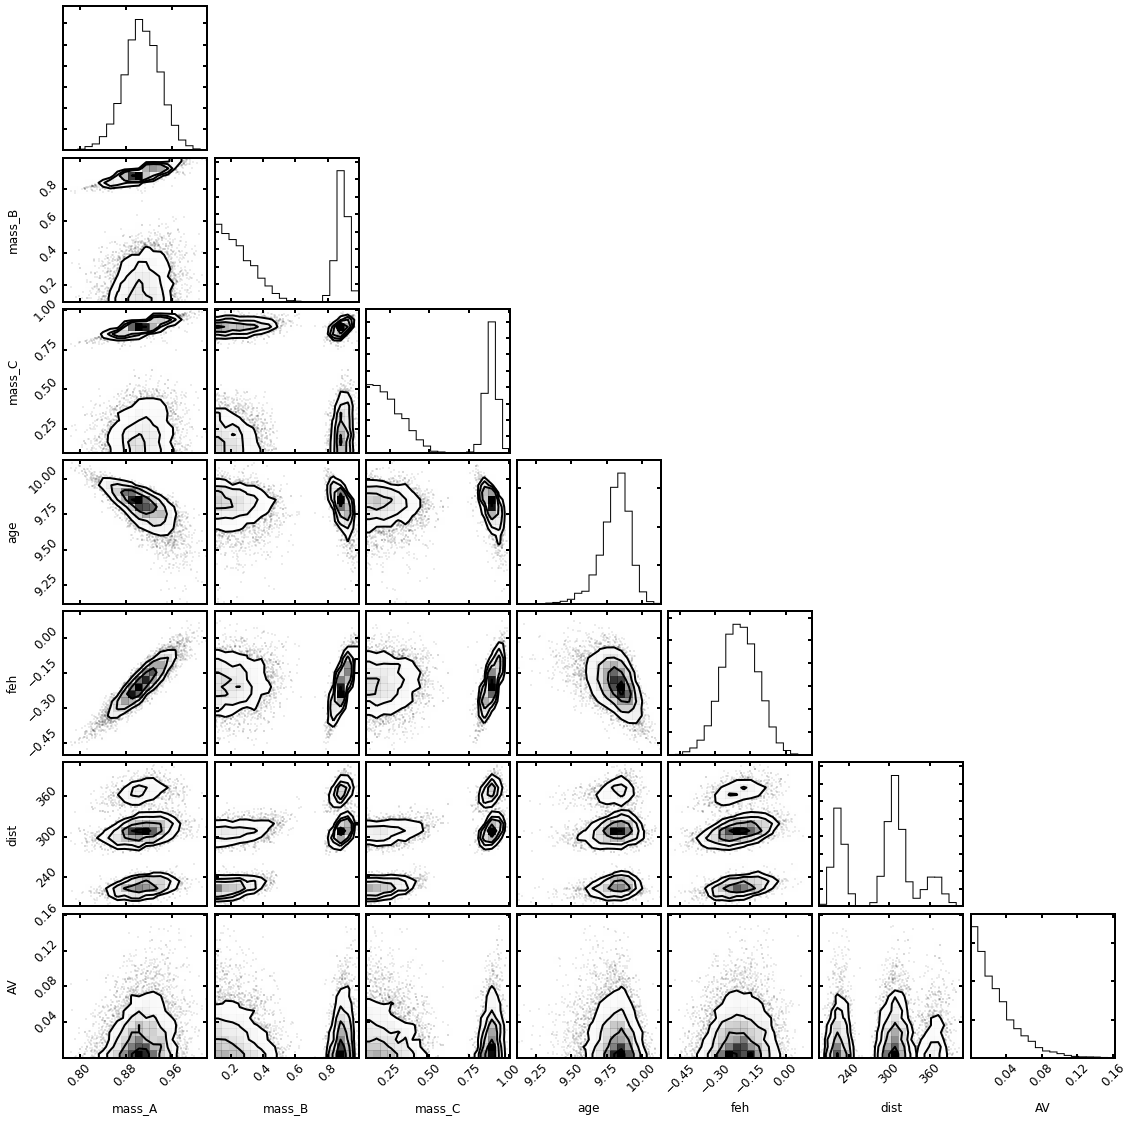

In [6]:
%matplotlib inline
import corner
corner.corner(a.get_equal_weighted_posterior()[:,:-1], labels=['mass_A','mass_B','mass_C','age','feh','dist','AV']);

In [29]:
import matplotlib.pyplot as plt
(a.get_equal_weighted_posterior()[:,2] > a.get_equal_weighted_posterior()[:,1]).sum()

3959

In [19]:
mod.bounds('mass')

(0.099009, 3.7357980000000004)

In [21]:
mod.obs.leaf_labels

['0_0', '0_1']

In [6]:
mod.samples.columns

Index([u'B_mag_0_0', u'D51_mag_0_0', u'H_mag_0_0', u'I_mag_0_0', u'J_mag_0_0',
       u'K_mag_0_0', u'Kepler_mag_0_0', u'R_mag_0_0', u'Teff_0_0',
       u'U_mag_0_0', u'V_mag_0_0', u'W1_mag_0_0', u'W2_mag_0_0', u'W3_mag_0_0',
       u'age_0_0', u'g_mag_0_0', u'i_mag_0_0', u'logL_0_0', u'logg_0_0',
       u'mass_0_0', u'r_mag_0_0', u'radius_0_0', u'z_mag_0_0', u'B_mag_0_1',
       u'D51_mag_0_1', u'H_mag_0_1', u'I_mag_0_1', u'J_mag_0_1', u'K_mag_0_1',
       u'Kepler_mag_0_1', u'R_mag_0_1', u'Teff_0_1', u'U_mag_0_1',
       u'V_mag_0_1', u'W1_mag_0_1', u'W2_mag_0_1', u'W3_mag_0_1', u'age_0_1',
       u'g_mag_0_1', u'i_mag_0_1', u'logL_0_1', u'logg_0_1', u'mass_0_1',
       u'r_mag_0_1', u'radius_0_1', u'z_mag_0_1', u'age_0', u'feh_0',
       u'distance_0', u'AV_0', u'lnprob'],
      dtype='object')

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

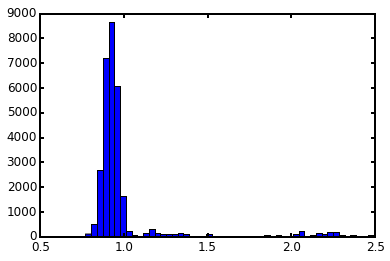

In [8]:
plt.hist(mod.sampler.flatchain[:,0], bins=50);

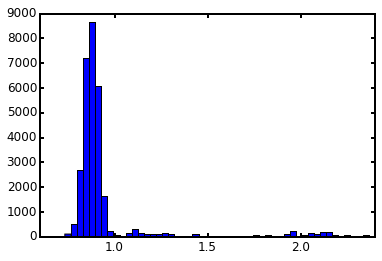

In [9]:
plt.hist(mod.sampler.flatchain[:,1], bins=50);

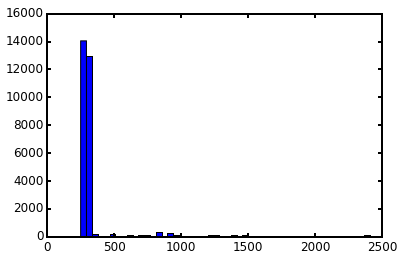

In [11]:
plt.hist(mod.sampler.flatchain[:,-2], bins=50);

In [22]:
ok = mod.sampler.acceptance_fraction > 0.15

In [24]:
chains = mod.sampler.chain[ok,:,:]
flatchain = chains.reshape((chains.shape[0]*chains.shape[1], chains.shape[2]))

In [30]:
flatchain.shape

(25900, 5)

In [15]:
import corner

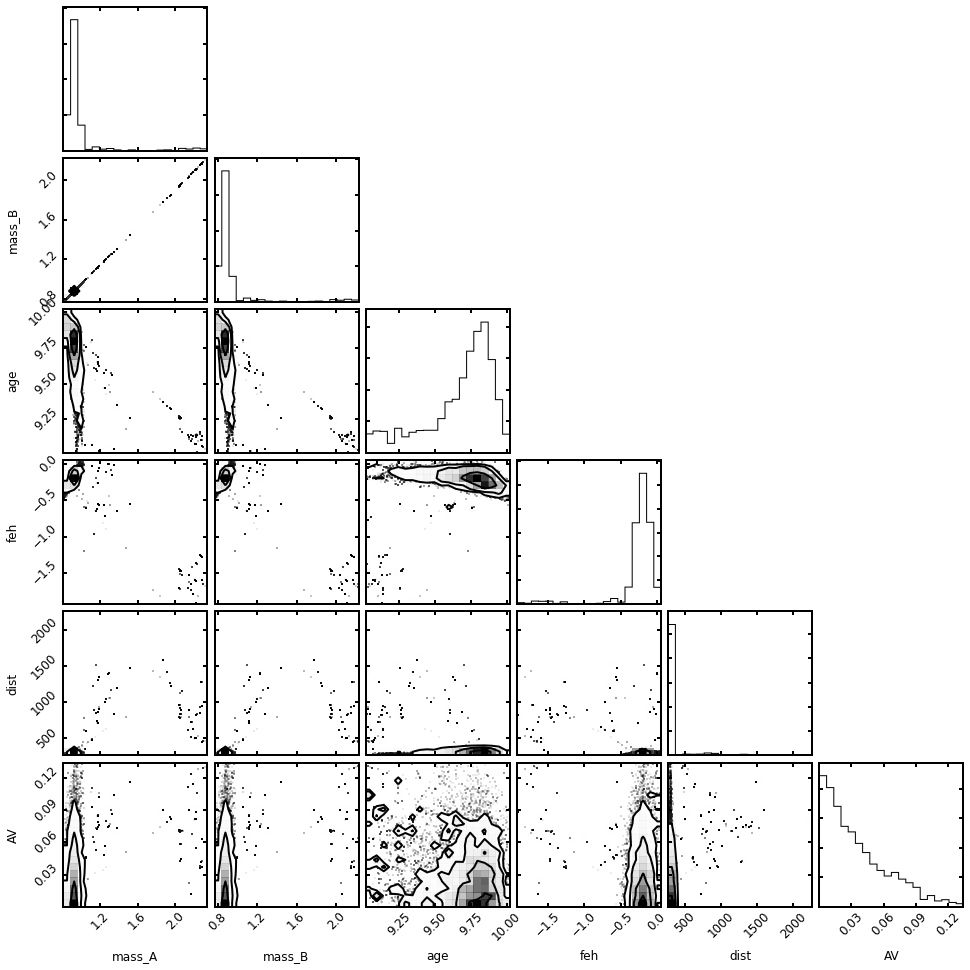

In [18]:
corner.corner(mod.sampler.flatchain, labels=['mass_A','mass_B','age','feh','dist','AV'],
      range=[0.99]*6);

In [27]:
corner?

In [11]:
import numpy as np
w = np.where(mod.sampler.acceptance_fraction < 0.02)[0]

In [14]:
w

array([ 31,  52, 126, 135, 138, 158, 189, 203, 227, 234, 238, 260, 286])

In [13]:
mod.sampler.lnprobability[w,:]

array([[-1992.77309527, -1992.77309527, -1992.77309527, ...,
        -1982.88000477, -1982.88000477, -1982.88000477],
       [ -435.98091428,  -435.98091428,  -435.98091428, ...,
         -435.98091428,  -435.98091428,  -435.98091428],
       [-2021.77541384, -2021.77541384, -2021.77541384, ...,
        -2021.77541384, -2021.77541384, -2021.77541384],
       ..., 
       [-1597.43446916, -1597.43446916, -1597.43446916, ...,
        -1597.43446916, -1597.43446916, -1597.43446916],
       [-9811.28772754, -9811.28772754, -9811.28772754, ...,
        -9811.28772754, -9811.28772754, -9811.28772754],
       [ -623.57743604,  -623.57743604,  -623.57743604, ...,
         -623.57743604,  -623.57743604,  -623.57743604]])

In [32]:
mod.obs.print_ascii(p=[  1.92184216e+00,   9.33893417e+00,  -1.64027746e+00,
           7.95152588e+02,   3.49565065e-02])

root
 ╚═  g=(12.0428791, 0.05) @(0.00, 0); model=13.84 (-648.684793896)
    ╚═  i=(11.4300704, 0.05) @(0.00, 0); model=12.11 (-93.0863262807)
       ╚═  H=(10.211, 0.02) @(0.00, 0); model=10.01 (-50.1804271819)
          ╚═  K=(10.152, 0.02) @(0.00, 0); model=9.86 (-105.531685863)
             ╚═  J=(10.523, 0.02) @(0.00, 0); model=10.64 (-17.3762979042)
                ╚═  r=(11.5968652, 0.05) @(0.00, 0); model=12.60 (-202.762588846)
                   ╚═  z=(11.393061, 0.05) @(0.00, 0); model=11.83 (-38.9604032731)
                      ╚═ 0_0, logg=(4.443, 0.028); model=0.362635365816 (-10618.2242015), Teff=(5642, 50.0); model=4132.02445185 (-456.0052312), feh=(-0.27, 0.08); model=-1.64027746 (-146.692212296): [1.92184216, 9.33893417, -1.64027746, 795.152588, 0.0349565065]


In [31]:
mod._sampler.chain[w,:,:]

array([[[  1.92184216e+00,   9.33893417e+00,  -1.64027746e+00,
           7.95152588e+02,   3.49565065e-02],
        [  1.92184216e+00,   9.33893417e+00,  -1.64027746e+00,
           7.95152588e+02,   3.49565065e-02],
        [  1.92184216e+00,   9.33893417e+00,  -1.64027746e+00,
           7.95152588e+02,   3.49565065e-02],
        ..., 
        [  1.92241484e+00,   9.33868504e+00,  -1.64112972e+00,
           7.95481870e+02,   3.49549428e-02],
        [  1.92241484e+00,   9.33868504e+00,  -1.64112972e+00,
           7.95481870e+02,   3.49549428e-02],
        [  1.92241484e+00,   9.33868504e+00,  -1.64112972e+00,
           7.95481870e+02,   3.49549428e-02]],

       [[  1.28249943e+00,   9.55082459e+00,  -1.69793865e-01,
           1.41976964e+03,   1.13836291e-01],
        [  1.28249943e+00,   9.55082459e+00,  -1.69793865e-01,
           1.41976964e+03,   1.13836291e-01],
        [  1.28249943e+00,   9.55082459e+00,  -1.69793865e-01,
           1.41976964e+03,   1.13836291e-01],
   

In [9]:
mod.obs.print_ascii()

root
 ╚═  g=(12.0428791, 0.05) @(0.00, 0)
    ╚═  i=(11.4300704, 0.05) @(0.00, 0)
       ╚═  H=(10.211, 0.02) @(0.00, 0)
          ╚═  K=(10.152, 0.02) @(0.00, 0)
             ╚═  J=(10.523, 0.02) @(0.00, 0)
                ╚═  r=(11.5968652, 0.05) @(0.00, 0)
                   ╚═  z=(11.393061, 0.05) @(0.00, 0)
                      ╚═ 0_0, logg=(4.443, 0.028), Teff=(5642, 50.0), feh=(-0.27, 0.08)


In [10]:
p = [1.0,9.7,0.0,400,0.1]
#p = [1.0,0.5,9.7,0.0,400,0.1]
#p = [1.0,9.7,0.0,400,0.1,0.5,9.5,0.1,200,0.05]
mod.lnpost(p)

-5679.9940594470645

In [12]:
mod.obs.print_ascii(p=p)

root
 ╚═  g=(12.0428791, 0.05) @(0.00, 0); model=13.19 (-264.626669315)
    ╚═  i=(11.4300704, 0.05) @(0.00, 0); model=12.54 (-244.203922072)
       ╚═  H=(10.211, 0.02) @(0.00, 0); model=11.32 (-1528.74681339)
          ╚═  K=(10.152, 0.02) @(0.00, 0); model=11.27 (-1573.93516209)
             ╚═  J=(10.523, 0.02) @(0.00, 0); model=11.64 (-1570.77382855)
                ╚═  r=(11.5968652, 0.05) @(0.00, 0); model=12.67 (-228.202854372)
                   ╚═  z=(11.393061, 0.05) @(0.00, 0); model=12.51 (-248.905354969)
                      ╚═ 0_0, logg=(4.443, 0.028); model=4.42463013439 (-0.215211710698), Teff=(5642, 50.0); model=5787.92381877 (-4.25875217665), feh=(-0.27, 0.08); model=0.0 (-5.6953125): [1.0, 9.7, 0.0, 400, 0.1]


In [13]:
mod.

10000 loops, best of 3: 48.6 µs per loop


In [5]:
mod.lnprior(p)

-12.000986578687158

In [7]:
mod.prior('feh',0.0)

6.0236231643156257

In [8]:
mod.prior('distance',400)

-10.937561320066667

In [9]:
mod.prior('AV',0.1)

1.0

In [6]:
mod.prior('age',9.7)

0.8809172437280051

In [6]:
mod.prior('mass',1.0)

0.06042284436470413

In [12]:
mod._bounds

{'AV': (0, 1.0),
 'age': (9, 10.176091259055681),
 'distance': (0, 3000.0),
 'feh': (-2.5, 0.5),
 'mass': None,
 'q': (0.1, 1.0)}

In [8]:
for prop in ['age','feh','distance','AV']:
    print mod.bounds(prop)

(9, 10.176091259055681)
None
(0, 3000.0)
(0, 1.0)


In [20]:
mod.obs.print_ascii(p=p)

root
 ╚═  H=(11.5, 0.05) @(0.00, 0); model=11.23 (-14.6400966608)
    ╚═  K=(11.0, 0.05) @(0.00, 0); model=11.17 (-5.9310254073)
       ╚═  J=(12, 0.05) @(0.00, 0); model=11.58 (-35.8457671355)
          ╠═ 0_0, logg=(4.5, 0.1); model=4.42463013439 (-0.284030832072), Teff=(5700, 200); model=5787.92381877 (-0.0966324738298): [1.0, 9.7, 0.0, 400, 0.1]
          ╚═ 0_1: [0.5, 9.7, 0.0, 400, 0.1]


In [7]:
import numpy as np
np.log(0)

-inf

In [8]:
np.isinf(-np.inf)

True

In [17]:
l = [3,1,20,5,10,2]
m = l[1:4]
m.sort()
m
l

[3, 1, 20, 5, 10, 2]

In [18]:
l

[3, 1, 20, 5, 10, 2]

In [19]:
sorted(l)

[1, 2, 3, 5, 10, 20]

In [11]:
import corner

In [ ]:
corner.